In [1]:
%run setup_workspace.ipynb # loads data

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from datetime import date
from keras import backend as K 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
data = energy_consumption#daily_energy_consumption
data.ds.min(), data.ds.max()

(Timestamp('2011-01-01 01:00:00'), Timestamp('2018-08-03 00:00:00'))

# Creating a Neural Network Model

## 1. Train-test-validation-split

In [4]:
split_date = pd.Timestamp(date(2015,1,1))
split_date2 = pd.Timestamp(date(2016,1,1))
min_date = pd.Timestamp(date(2010,1,1))
max_date = pd.Timestamp(date(2017,1,1))

train = data[data.ds < split_date]
if min_date is not None:
    train = train[train['ds'] > min_date]

valid = data[(data.ds > split_date) & (data.ds < split_date2)]

test = data[data.ds > split_date2]
if max_date is not None:
    test = test[test['ds'] < max_date]

In [5]:
input_len = 8
train_generator = TimeseriesGenerator(train.y.values, train.y.values, length=input_len, batch_size=1)
test_generator = TimeseriesGenerator(test.y.values, test.y.values, length=input_len, batch_size=1)
valid_generator = TimeseriesGenerator(valid.y.values, valid.y.values, length=input_len, batch_size=1)

## Visualization

In [6]:
train.set_index('ds').y.plot(figsize=(14,7))

## 2. Model training

In [7]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=input_len))
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                450       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [8]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=150, verbose=0, 
                               callbacks=[earlyStopping], 
                               validation_data=valid_generator)

Instructions for updating:
Use tf.cast instead.


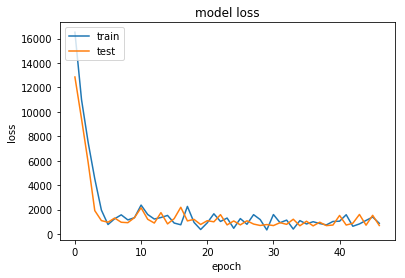

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 3. Forecast

In [11]:
prediction = model.predict_generator(test_generator)

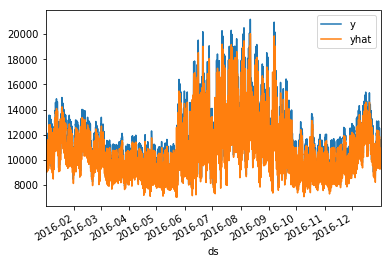

In [12]:
tmp = test.copy().iloc[input_len:,:]
tmp['yhat'] = prediction
tmp.set_index('ds', drop=True).plot()

## 4. Evaluation

In [13]:
error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
print('MAPE:%0.2f%%'%error)

MAPE:21.83%


In [14]:
mape_results = []
for i in range(0,30):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_len))
    model.add(Dense(1))
    model.compile(optimizer='adadelta', loss='mae')
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

    history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=150, verbose=0, 
                               callbacks=[earlyStopping], 
                               validation_data=valid_generator)
    
    prediction = model.predict_generator(test_generator)
    
    error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
    print('MAPE:%0.2f%%'%error)
    mape_results.append(error)

print(np.mean(mape_results))

MAPE:24.24%
MAPE:21.60%
MAPE:25.20%
MAPE:22.59%
MAPE:22.77%
MAPE:22.11%


KeyboardInterrupt: 